In [80]:
import cv2

import numpy as np
import pandas as pd
from joblib import load, dump

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.callbacks import TensorBoard
from keras import optimizers

nPoints = 18

KEYPOINTS = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16]]

POSE_PAIRS_MOD = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [8,11]]

def plotSinglePose(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        
        for pair in POSE_PAIRS:
            # Checking just xcoord for valid point is enough
            valid_pt1 = (posePoint[pair[0]][0] != -1)
            valid_pt2 = (posePoint[pair[1]][0] != -1)
            if valid_pt1 and valid_pt2:
                xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()

def plotSinglePose_mod(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        with plt.style.context('Solarize_Light2'):
            for pair in POSE_PAIRS_MOD:
                # Checking just xcoord for valid point is enough
                valid_pt1 = (posePoint[pair[0]][0] != -1)
                valid_pt2 = (posePoint[pair[1]][0] != -1)
                if valid_pt1 and valid_pt2:
                    xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                    ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                    plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()        
        
def flat_to_pose(flatPose):
    pose_dim = flatPose.reshape((-1, 2))
    
    return {i:pose_dim[i].tolist() for i in range(0, len(pose_dim))}
    

pose_data_file = "../data/frames/forRNN_pose_by_daner.out"
pose_data_by_dancer = load(pose_data_file)

In [95]:
dancers = len(pose_data_by_dancer)
X = []
y = []
seqLen = 40
slide = 1

for dancer in range(dancers):
    pose_coords = pose_data_by_dancer[dancer]
    poses = len(pose_coords)
    if poses<60:
        continue #go to next dancer
    
    for i in range(0, poses - seqLen, slide):
        X.append(pose_coords[i:i+seqLen])
        y.append(pose_coords[i+seqLen])

X = np.array(X)
y = np.array(y)

In [96]:
print(X.shape)
print(y.shape)

#X = np.delete(X, [0, 1, 30, 31, 32, 33, 34, 35], axis=2)
#y = np.delete(y, [0, 1, 30, 31, 32, 33, 34, 35], axis=1)
print(X.shape)
print(y.shape)

(32864, 40, 36)
(32864, 36)
(32864, 40, 36)
(32864, 36)


In [97]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', min_delta = 0.001, patience=6, verbose=1)
tb = TensorBoard(histogram_freq=1, write_grads=True)

kpoints = 36

# Model
print('Build model...')
salsa_model = Sequential()
salsa_model.add(LSTM(kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True, kernel_initializer='random_uniform',
                bias_initializer='zeros', dropout = 0.2, recurrent_dropout = 0.2))
salsa_model.add(LSTM(kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True, kernel_initializer='random_uniform',
                bias_initializer='zeros', dropout = 0.2, recurrent_dropout = 0.2))
salsa_model.add(LSTM(kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=False, kernel_initializer='random_uniform',
                bias_initializer='zeros', dropout = 0.2, recurrent_dropout = 0.2))
salsa_model.add(Dense(kpoints))
adm = optimizers.Adam(lr=0.001, decay=)
salsa_model.compile(optimizer=adm, loss='mse', metrics=['mse'])
hist = salsa_model.fit(X, y, epochs=40, verbose=True, callbacks=[early_stopping])

#optimizer = RMSprop(lr=0.0

Build model...
Epoch 1/40
32864/32864 [==============================] - 100s 3ms/step - loss: 5802687.2951 - mean_squared_error: 5802687.2951
Epoch 2/40
32864/32864 [==============================] - 101s 3ms/step - loss: 69380.0536 - mean_squared_error: 69380.0536
Epoch 3/40
32864/32864 [==============================] - 100s 3ms/step - loss: 60879.2280 - mean_squared_error: 60879.2280
Epoch 4/40
32864/32864 [==============================] - 100s 3ms/step - loss: 527826042765.8378 - mean_squared_error: 527826042765.8378
Epoch 5/40
32864/32864 [==============================] - 100s 3ms/step - loss: 51539.5352 - mean_squared_error: 51539.5352
Epoch 6/40
32864/32864 [==============================] - 100s 3ms/step - loss: 122586595.8294 - mean_squared_error: 122586595.8294
Epoch 7/40
32864/32864 [==============================] - 101s 3ms/step - loss: 18734950.4157 - mean_squared_error: 18734950.4157
Epoch 8/40
32864/32864 [==============================] - 101s 3ms/step - loss: 51868

In [283]:
#--- Early Stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

#--- History
hist = model.fit(x, y, validation_split=0.2)
print(hist.history)


#--- Save a Keras Model
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

NameError: name 'model' is not defined

In [98]:
salsa_model.save("../models/threelayerLSTM_relu_36kp_8seql_dropoutlr_0.01lr.h5")

In [54]:
def genSalsa(seedPoses, salsaModel, steps = 8):
    seqLen = seedPoses.shape[1]
    for i in range(steps):
        y_pred = salsa_model.predict(seedPoses[:,-(seqLen):,:])
        seedPoses = np.append(seedPoses, [y_pred], axis=1)
    return seedPoses

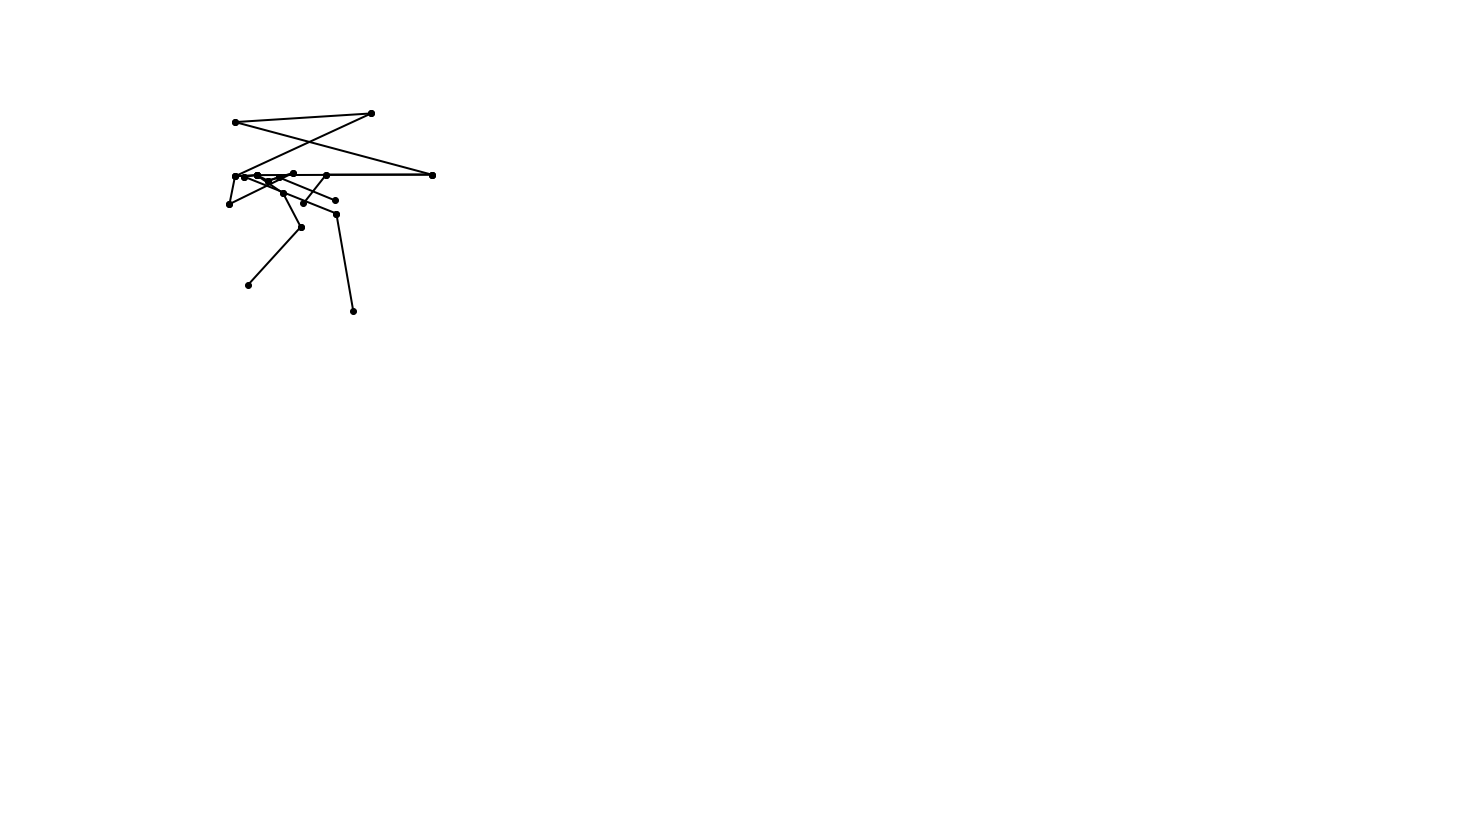

"\nfor i in range(0, 2):    \n    y_test = salsa_model.predict(x)\n    print(x.shape)\n    print(y_test.shape)\n    np.append(x, [y_test], axis = 1)\n    print(x.shape)\n    x = np.delete(x, 0, axis=1)\n    print(x.shape)\n    #plt.rcParams['figure.figsize'] = [30, 15]\n    #plotSinglePose(flat_to_pose(y_test))\n    #time.sleep(60)\n    print(y_test)\n"

In [106]:
#from keras.models import load_model
#salsa_model = load_model("../models/threelayerLSTM.h5")
import time

d = 3#np.random.randint(31, 39)
p = np.random.randint(0, len(pose_data_by_dancer[d]))
x = np.array([pose_data_by_dancer[d][p: p+seqLen]])
gen_salsa = genSalsa(x, salsa_model, 48)
y_test = salsa_model.predict(x)
#print(x)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose(flat_to_pose(y_test))

#x = X = np.delete(x, [0, 1, 30, 31, 32, 33, 34, 35], axis=2)
'''
for i in range(0, 2):    
    y_test = salsa_model.predict(x)
    print(x.shape)
    print(y_test.shape)
    np.append(x, [y_test], axis = 1)
    print(x.shape)
    x = np.delete(x, 0, axis=1)
    print(x.shape)
    #plt.rcParams['figure.figsize'] = [30, 15]
    #plotSinglePose(flat_to_pose(y_test))
    #time.sleep(60)
    print(y_test)
'''

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


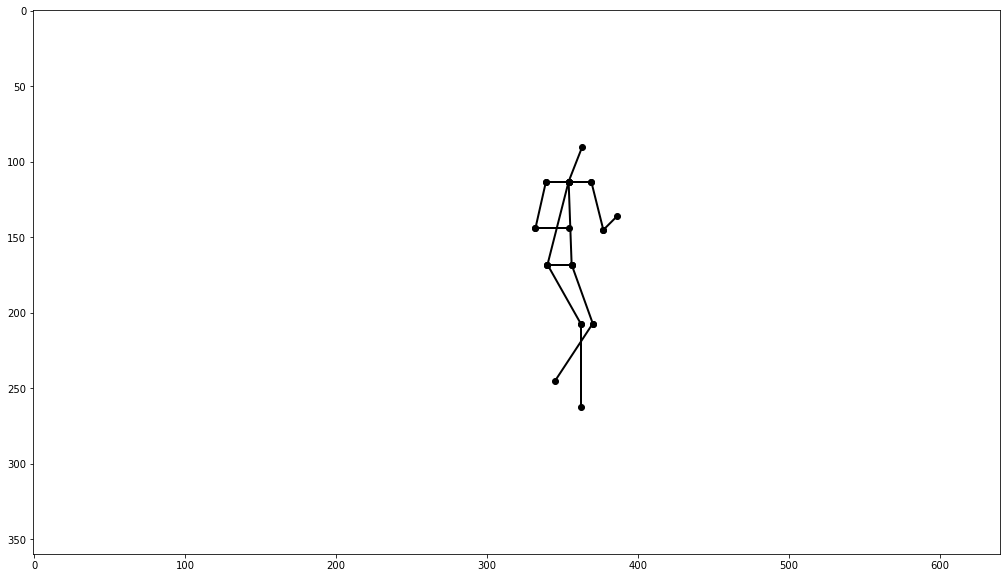

In [107]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

x_for_anim = gen_salsa

plt.rcParams['figure.figsize'] = [20, 10]                              
fig = plt.figure()
ax = plt.axes(xlim=(0, 640), ylim=(0, 360))
                              
def animate(i):
    ax.clear()
    pose = x_for_anim[0][i].reshape((-1, 2))
    #print(pose)
    imgArray = np.ones((360, 640))
    ax.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
    for pair in POSE_PAIRS_MOD:
        # Checking just xcoord for valid point is enough
        valid_pt1 = (pose[pair[0]][0] != -1)
        valid_pt2 = (pose[pair[1]][0] != -1)
        if valid_pt1 and valid_pt2:
            xs = [pose[pair[0]][0], pose[pair[1]][0]]
            ys = [pose[pair[0]][1], pose[pair[1]][1]]
            ax.plot(xs, ys,'ko-', linewidth=2)                         

anim = FuncAnimation(fig, animate, frames=56, interval=125)
anim
anim.save('temp4a.gif', writer='imagemagick')

In [113]:
salsa_model.weights
#w= salsa_model.get_weights()

[<tf.Variable 'lstm_13/kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_13/recurrent_kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_13/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'lstm_14/kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_14/recurrent_kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_14/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'lstm_15/kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_15/recurrent_kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_15/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'dense_5/kernel:0' shape=(36, 36) dtype=float32_ref>,
 <tf.Variable 'dense_5/bias:0' shape=(36,) dtype=float32_ref>]

In [922]:
x = np.delete(x, [0, 1, 32, 33, 34, 35], axis=2)
print(x.shape)

(1, 16, 28)


//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [873]:
a = np.ones((1,8, 36))
b = np.ones((1,36))*2
print(a.shape)
a = np.append(a, [b], axis=1)
np.delete(a, 0, axis=1)
print(a)

(1, 8, 36)
[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 

In [148]:
salsa_retrain = load_model("../models/twolayerLSTM.h5")
hist = salsa_retrain.fit(X, y, epochs=30, verbose=True)#, callbacks=[early_stopping])

Epoch 1/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5725 - mean_absolute_error: 53.8623 - acc: 0.0356
Epoch 2/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.6357 - mean_absolute_error: 53.8665 - acc: 0.0356
Epoch 3/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5952 - mean_absolute_error: 53.8773 - acc: 0.0356
Epoch 4/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5500 - mean_absolute_error: 53.8890 - acc: 0.0356
Epoch 5/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.6418 - mean_absolute_error: 53.8604 - acc: 0.0356
Epoch 6/30
16189/16189 [==============================] - 33s 2ms/step - loss: 6713.6420 - mean_absolute_error: 53.8643 - acc: 0.0356
Epoch 7/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5634 - mean_absolute_error: 53.8492 - acc: 0.0356
Epoch 8/30
16189/16189 [==============================] - 34s 

In [149]:
salsa_retrain.save("../models/twolayerLSTM_90Iterms.h5")

[[[300 136 299 ... 129 314 136]
  [276 129 284 ...  -1 293 129]
  [261 113 267 ...  -1 277 120]
  ...
  [308 113 308 ... 113 316 113]
  [306 114 307 ... 113 315 113]
  [306 121 300 ... 120 315 120]]]
[[293.59274 105.33664 314.54388 129.89502 301.70557 128.8758  279.8331
  139.32631 254.00594 130.66652 322.27377 128.92693 313.08234 138.97702
  285.19125 132.39873 307.73447 179.62575 304.30933 217.0111  302.84113
  252.84648 321.38504 179.76369 320.65366 217.1679  318.15872 254.05928
  265.9411   91.47726 266.76755  91.9408  218.38156  75.93291 210.40962
   75.38097]]


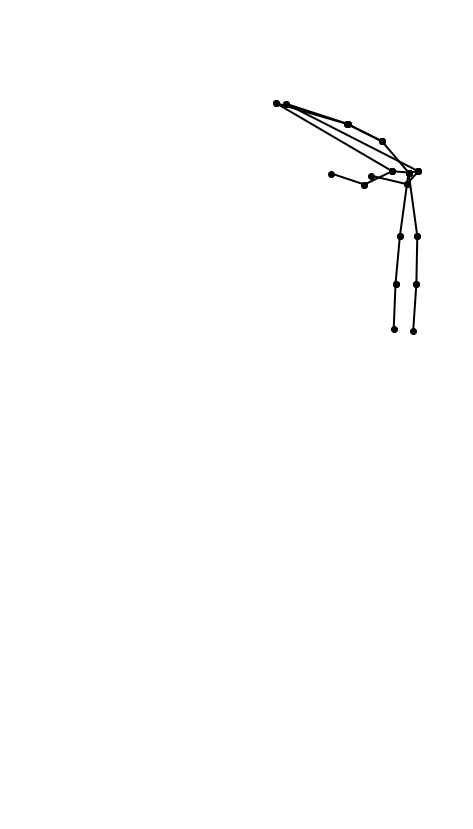

In [191]:
#from keras.models import load_model
#model_to_test = load_model("../models/twolayerLSTM.h5")

p = np.random.randint(0, 600)

x = np.array([pose_data_by_dancer[40][p: p+seqLen]])
#x = x[0:20]*0 
y = salsa_retrain.predict(x)
print(x)
print(y)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose(flat_to_pose(y))

In [167]:
wts = salsa_retrain.get_weights()
salsa_retrain.summary()
(10512-144)/(48*36)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 48, 36)            10512     
_________________________________________________________________
lstm_16 (LSTM)               (None, 36)                10512     
_________________________________________________________________
dense_7 (Dense)              (None, 36)                1332      
Total params: 22,356
Trainable params: 22,356
Non-trainable params: 0
_________________________________________________________________


6.0

In [135]:
from itertools import product

act_funcs = ['relu', 'tanh']
layers = [2, 3]
epochs = range(100, 250, 50)

for item in product(act_funcs, layers, epochs):
    print(item)

    
def salsa_model_template(item):
    """
    item is tuple (activation, no of layers, epochs)
    """
    
    
    
    

('relu', 2, 100)
('relu', 2, 150)
('relu', 2, 200)
('relu', 3, 100)
('relu', 3, 150)
('relu', 3, 200)
('tanh', 2, 100)
('tanh', 2, 150)
('tanh', 2, 200)
('tanh', 3, 100)
('tanh', 3, 150)
('tanh', 3, 200)
